In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [71]:
data_path = glob.glob('./a2_results/validation/*.csv')
data_path

['./a2_results/validation/validation_robot_item_collection_log_8.csv',
 './a2_results/validation/validation_robot_item_collection_log_9.csv',
 './a2_results/validation/validation_robot_item_collection_log_4.csv',
 './a2_results/validation/validation_robot_item_collection_log_5.csv',
 './a2_results/validation/validation_robot_item_collection_log_7.csv',
 './a2_results/validation/validation_robot_item_collection_log_6.csv',
 './a2_results/validation/validation_robot_item_collection_log_2.csv',
 './a2_results/validation/validation_robot_item_collection_log_3.csv',
 './a2_results/validation/validation_robot_item_collection_log_1.csv',
 './a2_results/validation/validation_robot_item_collection_log_10.csv']

In [100]:
def plot_lineplot(data_path, mvg_avg_window=4, figsize=(10, 12)):
    if 'train' in data_path[0]:
        temp_data = pd.read_csv(data_path[0])
        temp_data['episode'] = (temp_data['step'] == 0).cumsum()
        all_data_list = [temp_data]
    else:
        all_data_list = []
        for i, file in enumerate(data_path, 1):
            temp_data = pd.read_csv(file)
            temp_data['episode'] = i
            all_data_list.append(temp_data)

    all_data = pd.concat(all_data_list, ignore_index=True)
    if 'train' in data_path[0]:
        all_data['food_collected'] = None
        
    episode_stats = all_data.groupby('episode').agg(
        total_steps=('step', 'max'),
        total_rewards=('reward', 'sum'),
        total_food_collected=('food_collected', 'sum')
    ).reset_index()

    episode_stats['reward_std'] = all_data.groupby('episode')['reward'].std().reset_index(drop=True)
    episode_stats['food_std'] = all_data.groupby('episode')['food_collected'].std().reset_index(drop=True)
    episode_stats['rolling_avg_rewards'] = episode_stats['total_rewards'].rolling(window=mvg_avg_window).mean()


    # Calculate confidence intervals (95% CI)
    z = 1.96  # For 95% confidence
    episode_stats['reward_upper'] = episode_stats['total_rewards'] + z * (episode_stats['reward_std'] / np.sqrt(4))  # Assuming 4 samples/episode
    episode_stats['reward_lower'] = episode_stats['total_rewards'] - z * (episode_stats['reward_std'] / np.sqrt(4))
    episode_stats['food_upper'] = episode_stats['total_food_collected'] + z * (episode_stats['food_std'] / np.sqrt(4))
    episode_stats['food_lower'] = episode_stats['total_food_collected'] - z * (episode_stats['food_std'] / np.sqrt(4))

    # Plot with confidence intervals
    num_plot = 3
    draw_food = True
    if 'train' in data_path[0]:
        num_plot = 2
        draw_food = False
    fig, axs = plt.subplots(num_plot, 1, figsize=figsize)

    # First subplot: Total steps per episode (no CI needed)
    axs[0].plot(episode_stats['episode'], episode_stats['total_steps'], marker='o', color='blue', label='Total Steps')
    axs[0].set_title('Total Steps Per Episode', fontsize=16)
    axs[0].set_xlabel('Episode', fontsize=14)
    axs[0].set_ylabel('Steps', fontsize=14)
    axs[0].legend(fontsize=12)
    axs[0].grid(True, linestyle='--', alpha=0.6)

    # Second subplot: Total rewards per episode with rolling average and CI
    axs[1].plot(episode_stats['episode'], episode_stats['total_rewards'], marker='o', color='orange', label='Total Rewards')
    axs[1].fill_between(
        episode_stats['episode'],
        episode_stats['reward_lower'],
        episode_stats['reward_upper'],
        color='orange',
        alpha=0.2,
        label='95% CI'
    )
    axs[1].plot(episode_stats['episode'], episode_stats['rolling_avg_rewards'], color='red', linestyle='--', label=f'Avg Rewards ({mvg_avg_window} episodes)')
    axs[1].set_title('Total Rewards Per Episode', fontsize=16)
    axs[1].set_xlabel('Episode', fontsize=14)
    axs[1].set_ylabel('Rewards', fontsize=14)
    axs[1].legend(fontsize=12)
    axs[1].grid(True, linestyle='--', alpha=0.6)

    # Third subplot: Total food collected per episode with CI
    if draw_food:
        axs[2].plot(episode_stats['episode'], episode_stats['total_food_collected'], marker='o', color='green', label='Total Food Collected')
        axs[2].fill_between(
            episode_stats['episode'],
            episode_stats['food_lower'],
            episode_stats['food_upper'],
            color='green',
            alpha=0.2,
            label='95% CI'
        )
        axs[2].set_title('Total Food Collected Per Run (with 95% CI)', fontsize=16)
        axs[2].set_xlabel('Run', fontsize=14)
        axs[2].set_ylabel('Food Collected', fontsize=14)
        axs[2].legend(fontsize=12)
        axs[2].grid(True, linestyle='--', alpha=0.6)

    # Adjust layout and spacing
    fig.tight_layout(pad=3.0)

    # Show the plot
    plt.show()

In [93]:
data_path = ["./a2_results/train_robot_item_collection_log.csv"]

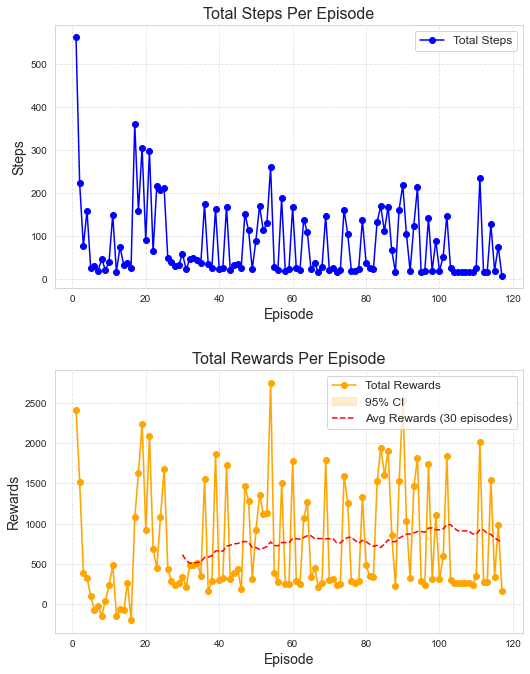

In [103]:
plot_lineplot(data_path, mvg_avg_window=30, figsize=(8, 10))

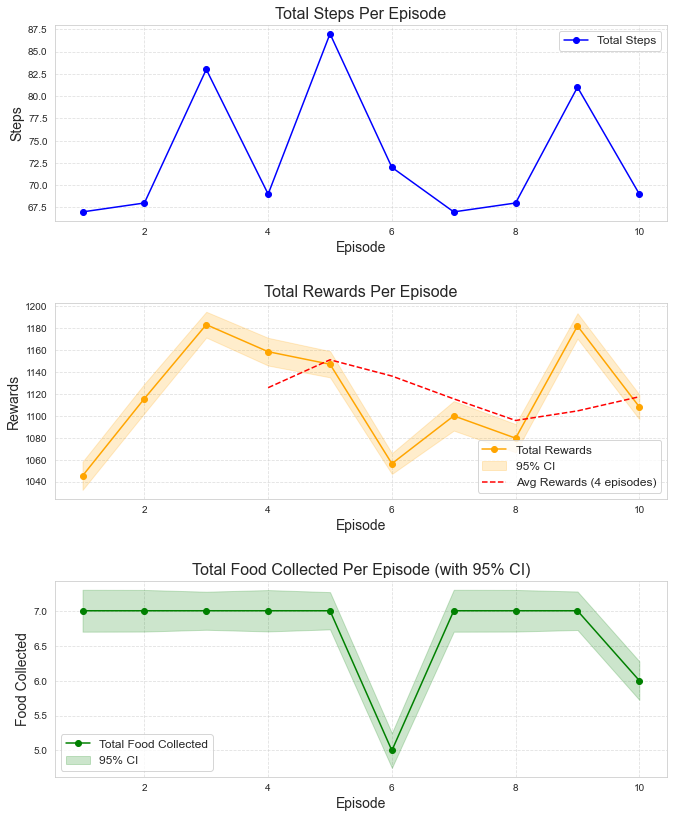

In [24]:
data_path = glob.glob('./a2_results/test/*.csv')
plot_lineplot(data_path)

In [69]:
def action_plot(data_path):
    # Read the CSV data
    data = pd.read_csv(data_path)
    
    # Convert 'step' and 'distance_to_lower_center' to numeric, coercing errors to NaN
    data['step'] = pd.to_numeric(data['step'], errors='coerce')
    data['distance_to_lower_center'] = pd.to_numeric(data['distance_to_lower_center'], errors='coerce')
    
    # Replace inf and -inf with NaN to create gaps in the plot
    data['distance_to_lower_center'].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Define action mapping: action name to unique integer
    action_unique = data['action'].unique()
    action_mapping = {action: idx for idx, action in enumerate(action_unique)}
    data['action_numeric'] = data['action'].map(action_mapping)
    
    # Define colors for all actions
    # Ensure that all actions present in the data have a color assigned
    # Add more actions and colors as needed
    predefined_colors = {
        'left': 'blue',
        'forward': 'orange',
        'right': 'green',
        'backward': 'red',
        # Example: 'stop': 'purple',
    }
    
    # Create a comprehensive action_colors dictionary
    action_colors = {}
    for action, idx in action_mapping.items():
        color = predefined_colors.get(action, 'grey')  # Default to grey if action not predefined
        action_colors[idx] = color
    
    # # Drop rows with NaN in essential columns
    # data = data.dropna(subset=['step', 'distance_to_lower_center'])
    
    # Sort data by step to ensure chronological order
    data = data.sort_values(by='step')
    data['food_collected'] = data['food_collected'].shift(periods=-1)
    
    # Initialize the plot
    plt.figure(figsize=(14, 7))
    
    # Plot 'distance_to_lower_center' as a black line
    plt.plot(
        data['step'],
        data['distance_to_lower_center'],
        color='grey',
        label='Distance to Lower Center',
        linewidth=2,
    )
    
    # Identify contiguous regions with the same action
    current_action = None
    start_step = None
    action_regions = []  # List to store tuples of (start_step, end_step, action_num)
    
    for idx, row in data.iterrows():
        action = row['action_numeric']
        step = row['step']
        
        if action != current_action:
            # If there's an existing action region, save it
            if current_action is not None and start_step is not None:
                end_step = prev_step
                action_regions.append((start_step, end_step, current_action))
            # Start a new action region
            current_action = action
            start_step = step
        prev_step = step
    
    # Add the last action region
    if current_action is not None and start_step is not None:
        end_step = data['step'].iloc[-1]
        action_regions.append((start_step, end_step, current_action))
    
    # Shade regions for each action using axvspan
    for region in action_regions:
        start, end, action_num = region
        color = action_colors.get(action_num, 'grey')  # Default to grey if action not mapped
        action_name = [k for k, v in action_mapping.items() if v == action_num][0]
        plt.axvspan(start, end, color=color, alpha=0.2, label=f"Action: {action_name}")
    
    # To prevent duplicate labels in the legend, handle labels separately
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=12)
    
    # Highlight points where food was collected
    if 'food_collected' in data.columns:
        food_collected_steps_cleaned = data[data['food_collected'] == True]
        if not food_collected_steps_cleaned.empty:
            plt.scatter(
                food_collected_steps_cleaned['step'],
                food_collected_steps_cleaned['distance_to_lower_center'],
                color='green',
                label='Food Collected',
                s=100,
                zorder=5,
                edgecolor='black',
                marker='*',
            )
            # Update legend to include 'Food Collected' without duplicates
            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            plt.legend(by_label.values(), by_label.keys(), fontsize=12)
    
    # Add titles, labels, and grid
    plt.title('Distance to the Food with Actions as Shaded Regions', fontsize=16)
    plt.xlabel('Step', fontsize=14)
    plt.ylabel('Distance to Lower Center', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Optimize layout and display the plot
    plt.tight_layout()
    plt.show()


In [58]:
data_path = glob.glob('./a2_results/test/*.csv')

In [66]:
data_path[3]

'./a2_results/test/test_robot_item_collection_log_4.csv'

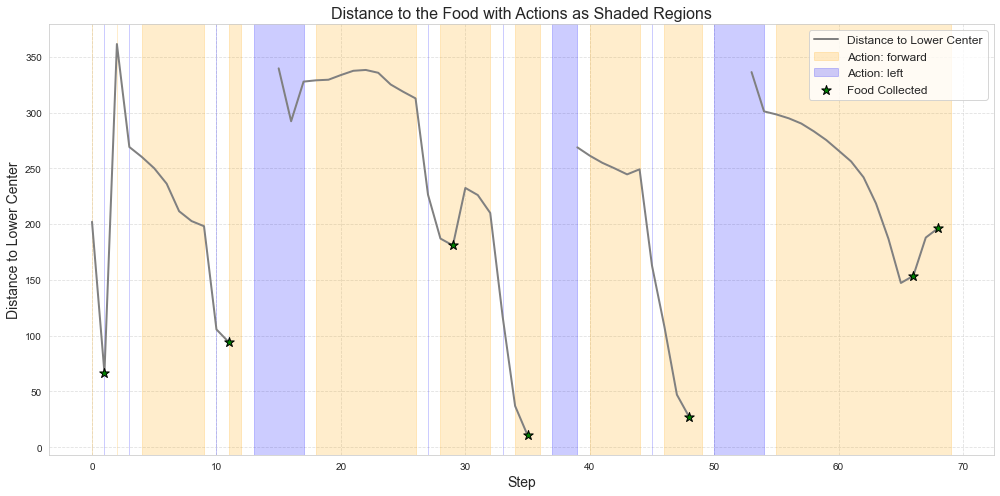

In [70]:
action_plot(data_path[3])